<a href="https://colab.research.google.com/github/NoeGille/UNet-on-fashion-mnist/blob/main/Fashion_MNIST_Florian_Reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
# import matplotlib
# matplotlib.use('TkAgg') # Necessary to run matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import albumentations as A
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


import copy

from collections import OrderedDict

from PIL import Image

In [ ]:
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch
import random

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 10
batch_size = 16
epochs = 10

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train = True, download=True)
valid_dataset = datasets.FashionMNIST(root='./data', train = False, download=True)

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, dataset, transform = None, 
                 shape = 224, labels = [1, 2, 3], 
                 not_labels = [5, 6, 7], background_obj = 3, 
                 include_label = True, length = 10000):
        self.dataset = dataset
        self.transform = transform
        self.shape = shape
        self.labels = labels
        self.not_labels = not_labels
        self.background_obj = background_obj
        self.include_label = include_label
        self.len = length
    
    def random_fashion_mnist(self):
        idx = np.random.randint(0, len(self.dataset))

        img, label = self.dataset[idx]
        img = transforms.ToTensor()(img)
        return img, label
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        
        image = torch.zeros((1, self.shape, self.shape))#, dtype=torch.uint8)
        mask = torch.zeros((self.shape, self.shape))#, dtype=torch.uint8)

        x = random.randint(14, self.shape - 114)
        y = x

        points = [(x, y), (x + 100, y), (x + 100, y + 100), (x, y + 100)]

        for i in points:
            while True:
              img, label = self.random_fashion_mnist()
              if label in self.labels:
                break
            
            x_pos, y_pos = i[0] - 14, i[1] - 14
            image[:, x_pos:x_pos+28, y_pos:y_pos+28] = img * image[:, x_pos:x_pos+28, y_pos:y_pos+28]
            mask[x_pos:x_pos+28, y_pos:y_pos+28] = self.include_label * label + 1
            mask[x_pos:x_pos + 28, y_pos:y_pos + 28][img[0, :, :] == 0] = 0
        
        for i in range(self.background_obj):
          while True:
              img, label = self.random_fashion_mnist()
              if label in self.not_labels:
                break
          while True:
            x = random.randint(0, self.shape - 28)
            y = x
            if (mask[x:x+28, y:y+28] * img).sum().item() == 0:
                break
          image[:, x:x + 28, y:y + 28] = img * image[:, x:x + 28, y:y + 28]
        
        if self.transform is not None:
            image = image.permute(1, 2, 0)
            image = np.array(image)
            mask = np.array(mask)
            transformed = self.transform(image = image, mask = mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = transforms.ToTensor()(image).to(torch.float)
            mask = torch.from_numpy(mask).long()
        return image, mask
    

In [ ]:
p = 0.1
p_ = 0.2

train_transform = A.Compose(
    [
        A.HorizontalFlip(p = p),
        A.VerticalFlip(p = p),
        A.geometric.rotate.Rotate(limit = 180, p = p_),
    ]
)

valid_transform = A.Compose(
    [
        
    ]
)

In [ ]:
labels = [1, 2, 3]
not_labels = [1, 2, 3, 5, 6, 7]
num_background = 5
train_len = 2000
valid_len = 2000

train_data = FashionMNISTDataset(dataset = train_dataset, transform = train_transform, length = train_len, labels = labels, not_labels = not_labels, background_obj = num_background)#None)#transform = train_transform)
valid_data = FashionMNISTDataset(dataset = valid_dataset, transform = valid_transform, length = valid_len, labels = labels, not_labels = not_labels, background_obj = num_background)#transform = None)#valid_transform)
print(len(train_data), len(valid_data))

2000 2000


torch.Size([1, 224, 224]) torch.Size([224, 224])


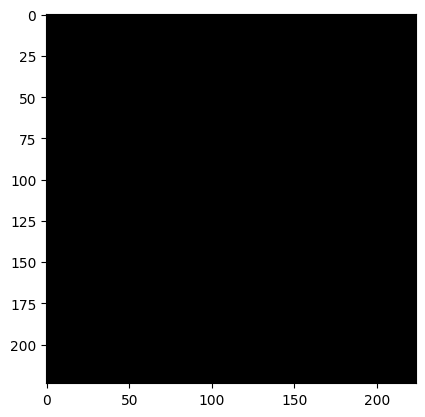

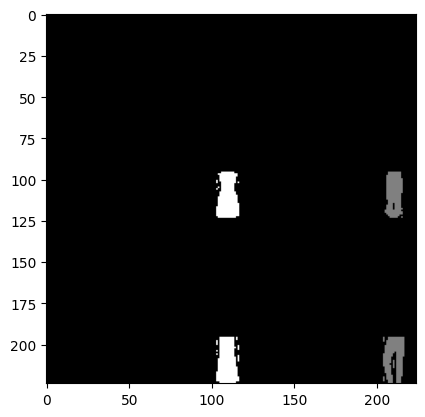

In [ ]:
sample_image, sample_mask = train_data[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, cmap = 'gray')

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(valid_data, batch_size = 16, shuffle = True)

In [ ]:
# Experiments

## Different classes for foreground and background objects
## Intersecting classes for foreground and background objects

### Train shallow and deep models
### Visualize predictions once model has trained
### Evaluate using dice score
### Evaluate using precision and recall